# RNN Exercises
For these exercises we're using data from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/IPG2211A2N

In the exercises below you'll be asked to do the following:
* Perform standard imports, load & plot the dataset (code provided)
* Prepare data for an LSTM model
* Define the LSTM model, loss and optimization functions
* Train the model
* Evaluate the model on test data
* OPTIONAL: Plot the results

<div class="alert alert-danger" style="margin: 10px"><strong>IMPORTANT NOTE!</strong> Make sure you don't run the cells directly above the example output shown, <br>otherwise you will end up writing over the example output!</div>

## Perform standard imports, load and plot the dataset
Run the cells below to load the libraries needed for this exercise and the Energy Production dataset, and to plot the data.

In [1]:
# RUN THIS CELL
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('/content/Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


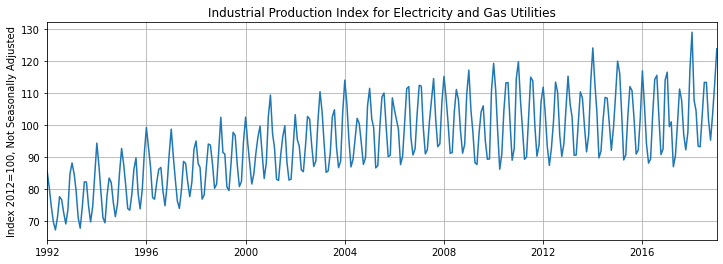

In [2]:
# RUN THIS CELL
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

# Prepare the data
For the first set of exercises we'll
* divide the data into train and test sets
* normalize the training set
* prepare windowed seq/label tuples for an LSTM model

## 1. Divide the data into train and test sets
Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [3]:
# CODE HERE
y = df['IPG2211A2N'].values.astype(float)

test_size = 12
train_set = y[:-test_size]
test_set = y[-test_size:]

In [4]:
# Run the code below to check your results:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


## 2. Normalize the training set
Feature scale the training set to fit within the range [-1,1].

In [5]:
# CODE HERE
# Normalize the training set
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [6]:
# Run the code below to check your results:
print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

First item, original: 85.556
First item, scaled:  [-0.4091274]


## 3. Prepare data for LSTM
Prepare the list of windowed sequence/label tuples to be fed into an LSTM model.

In [9]:
# RUN THIS CELL
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [11]:
# CODE HERE
window_size = 12
train_data = input_data(train_norm,window_size)
len(train_data)

301

In [12]:
# Run the code below to check your results:
print(f'Train_data: {len(train_data)}')  # should equal 301

Train_data: 301


## 4. Define the model
Design a model that has a (1,64) LSTM layer and a (64,1) fully-connected linear layer. Be sure to initialize $h_0$ and $c_0$, and return only the last predicted value.

In [15]:
# CODE HERE
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value
    
    

In [16]:
# Run the code below to check your results:
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

## 5. Define loss and optimization functions
Define a loss function called "criterion" and an optimizer called "optimizer".<br>
You can use any functions you want, although we used MSELoss and Adam (learning rate of 0.001) respectively.

In [17]:
# CODE HERE

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### 6. Train the model
Don't worry about tracking loss values, displaying results, or validating the test set. Just train the model through 50 epochs. We'll evaluate the trained model in the next step.<br>
OPTIONAL: print something after each epoch to indicate training progress.

In [18]:
# CODE HERE
epochs = 50

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')





Epoch:  1 Loss: 0.73148304
Epoch:  2 Loss: 0.32224372
Epoch:  3 Loss: 0.24065642
Epoch:  4 Loss: 0.22756004
Epoch:  5 Loss: 0.21153599
Epoch:  6 Loss: 0.19906583
Epoch:  7 Loss: 0.19067460
Epoch:  8 Loss: 0.18480708
Epoch:  9 Loss: 0.17962377
Epoch: 10 Loss: 0.17441951
Epoch: 11 Loss: 0.16898853
Epoch: 12 Loss: 0.16325682
Epoch: 13 Loss: 0.15732826
Epoch: 14 Loss: 0.15139408
Epoch: 15 Loss: 0.14566253
Epoch: 16 Loss: 0.14030810
Epoch: 17 Loss: 0.13544117
Epoch: 18 Loss: 0.13110320
Epoch: 19 Loss: 0.12727928
Epoch: 20 Loss: 0.12391785
Epoch: 21 Loss: 0.12095387
Epoch: 22 Loss: 0.11832561
Epoch: 23 Loss: 0.11598344
Epoch: 24 Loss: 0.11389026
Epoch: 25 Loss: 0.11202085
Epoch: 26 Loss: 0.11036178
Epoch: 27 Loss: 0.10891450
Epoch: 28 Loss: 0.10769790
Epoch: 29 Loss: 0.10674416
Epoch: 30 Loss: 0.10608405
Epoch: 31 Loss: 0.10575967
Epoch: 32 Loss: 0.10588426
Epoch: 33 Loss: 0.10653228
Epoch: 34 Loss: 0.10749183
Epoch: 35 Loss: 0.10844664
Epoch: 36 Loss: 0.10924798
Epoch: 37 Loss: 0.10987099
E

### 9. Evaluate the model using the test set
Be sure to re-initialize the hidden parameters $h_0$ and $c_0$ before running the model.

In [19]:
# CODE HERE
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())




In [20]:
# Run the code below to check your results:
preds[window_size:]

[0.25402793288230896,
 -0.002775115892291069,
 -0.34294819831848145,
 -0.2116757184267044,
 0.2391887605190277,
 0.4891482889652252,
 0.24707990884780884,
 -0.08662214130163193,
 -0.25781765580177307,
 0.02258598804473877,
 0.5441879630088806,
 0.6110795140266418]

## 10. Inverse transform the predicted values
Rescale the predicted values up to the original test set range.

In [21]:
# CODE HERE
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[105.95764234],
       [ 98.05722495],
       [ 87.59197015],
       [ 91.63050236],
       [105.50112262],
       [113.19100254],
       [105.74388986],
       [ 95.47771313],
       [ 90.21096873],
       [ 98.83744663],
       [114.88427059],
       [116.94215571]])

## BONUS EXERCISE: Plot the result
Plot the true_predictions values together with the original data. Remember to create a range of datetime values for the predicted data.

In [22]:
# CODE HERE
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')
x

array(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
      dtype='datetime64[D]')

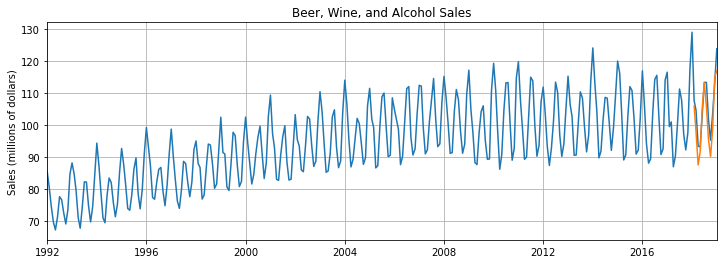

In [25]:
# CODE HERE TO DISPLAY THE END OF THE GRAPH
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

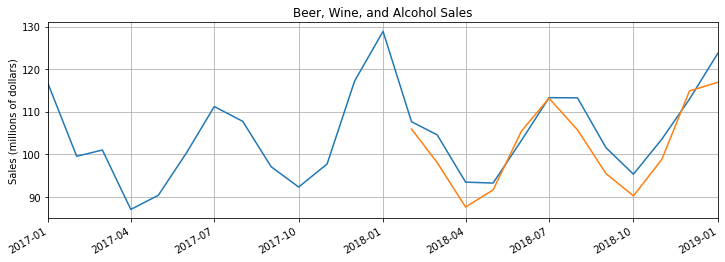

In [26]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

## Great job!